In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor

# Download Dataset

In [2]:
data = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv', delimiter=',\s+', engine='python')
data

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


# Exploratory Data Analysis

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


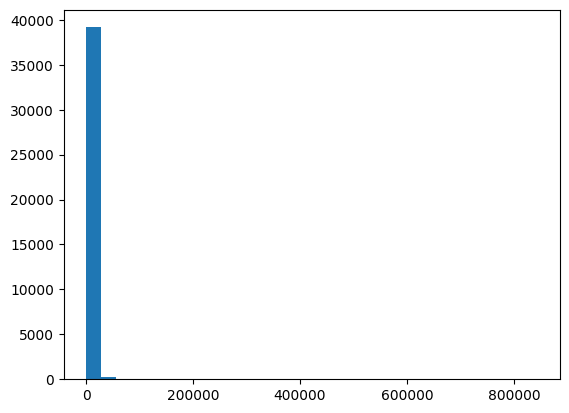

In [3]:
# 1. Plot the target variable. Determine if the target variable seems appropriate or if any transformations are needed.
shares = data.iloc[:, -1]

print(shares.describe())

plt.hist(shares, bins=30)

plt.show()

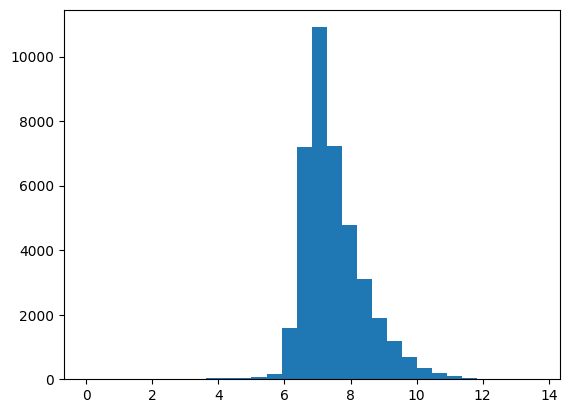

In [4]:
# Apply a log transform because the variables shares are heavily skewed
shares = np.log(shares)

plt.hist(shares, bins=30)

plt.show()

In [5]:
# 2. Build a linear regression model without higher-order terms and identify the most significant predictors.
def remove_worst_feature(model, X):
    worst_feature = model.pvalues.drop("const").idxmax()
    print(f"Removing {worst_feature} with p-value {model.pvalues.max()}")
    X = X.drop(worst_feature, axis=1)
    return X

def remove_insignificant_features(model, X, y, p=0.05):
    while model.pvalues.max() > p:
        X = remove_worst_feature(model, X)
        model = sm.OLS(y, X).fit()
    return model, X

X = data.drop(["shares", "url"], axis=1).astype(float)
X = sm.add_constant(X)
y = np.log(data["shares"]).astype(float)

linear_model = sm.OLS(y, X).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     101.0
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:24:13   Log-Likelihood:                -50705.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39586   BIC:                         1.020e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -23.9056    394.230     -0.061      0.952    -796.606     748.795
timedelta                      6.156e-05   2.97e-05      2.073      0.038    3.36e-06       0.000
n_tokens_title                    0.0081      0.002      3.689      0.000       0.004       0.012
n_tokens_content                4.06e-05   1.69e-05      2.401      0.016    7.45e-06    7.37e-05
n_unique_tokens                   0.1626      0.146      1.117      0.264      -0.123       0.448
n_non_stop_words                  0.0769      0.447      0.172      0.863      -0.800       0.953
n_non_stop_unique_tokens         -0.2426      0.123     -1.966      0.049      -0.484      -0.001
num_hrefs                         0.0042      0.001      8.290      0.000       0.003       0.005
num_self_hrefs                   -0.0080      0.001     -5.916      0.000      -0.011      -0.005
num_imgs                          0.0024      0.001      3.583      0.000       0.001       0.004
num_videos                        0.0019      0.001      1.601      0.109      -0.000       0.004
average_token_length             -0.0919      0.018     -4.997      0.000      -0.128      -0.056
num_keywords                      0.0119      0.003      4.250      0.000       0.006       0.017
data_channel_is_lifestyle        -0.1025      0.030     -3.427      0.001      -0.161      -0.044
data_channel_is_entertainment    -0.1797      0.019     -9.265      0.000      -0.218      -0.142
data_channel_is_bus              -0.1657      0.029     -5.721      0.000      -0.222      -0.109
data_channel_is_socmed            0.1607      0.028      5.698      0.000       0.105       0.216
data_channel_is_tech              0.1028      0.028      3.653      0.000       0.048       0.158
data_channel_is_world            -0.0385      0.029     -1.345      0.179      -0.095       0.018
kw_min_min                        0.0009      0.000      7.227      0.000       0.001       0.001
kw_max_min                     1.706e-05   3.81e-06      4.477      0.000    9.59e-06    2.45e-05
kw_avg_min                       -0.0001   2.34e-05     -5.438      0.000      -0.000   -8.15e-05
kw_min_max                    -3.535e-07   8.91e-08     -3.968      0.000   -5.28e-07   -1.79e-07
kw_max_max                     5.049e-08   4.46e-08      1.131      0.258    -3.7e-08    1.38e-07
kw_avg_max                    -2.872e-07   6.42e-08     -4.475      0.000   -4.13e-07   -1.61e-07
kw_min_avg                    -5.044e-05   5.72e-06     -8.812      0.000   -6.17e-05   -3.92e-05
kw_max_avg                    -4.188e-05   1.91e-06    -21.872      0.000   -4.56e-05   -3.81e-05
kw_avg_avg                        0.0003   1.09e-05     30.768      0.000       0.000       0.000
self_reference_min_shares      7.394e-07   5.

In [6]:
tuned_model, tuned_X = remove_insignificant_features(linear_model, X, y)
tuned_model.summary()

Removing self_reference_max_shares with p-value 0.9985226900284969
Removing avg_positive_polarity with p-value 0.9711122398764772
Removing weekday_is_saturday with p-value 0.9545461655077352
Removing is_weekend with p-value 0.954504779297568
Removing LDA_02 with p-value 0.9523481420501415
Removing min_negative_polarity with p-value 0.8893937148012816
Removing weekday_is_sunday with p-value 0.8860736278559992
Removing global_rate_negative_words with p-value 0.6270525305499173
Removing max_positive_polarity with p-value 0.3997371499615747
Removing n_non_stop_words with p-value 0.4461840216896025
Removing abs_title_sentiment_polarity with p-value 0.3781185119154119
Removing kw_max_max with p-value 0.25921229837016174
Removing data_channel_is_world with p-value 0.2210054254140665
Removing max_negative_polarity with p-value 0.21880833497861618
Removing num_videos with p-value 0.10673030213007241
Removing global_sentiment_polarity with p-value 0.07046144419701394
Removing self_reference_min_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     136.7
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:24:15   Log-Likelihood:                -50713.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39601   BIC:                         1.019e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.5863      0.054    122.400      0.000       6.481       6.692
timedelta                      5.821e-05   2.87e-05      2.031      0.042    2.04e-06       0.000
n_tokens_title                    0.0081      0.002      3.657      0.000       0.004       0.012
n_tokens_content               5.194e-05   1.26e-05      4.132      0.000    2.73e-05    7.66e-05
n_unique_tokens                   0.2624      0.109      2.399      0.016       0.048       0.477
n_non_stop_unique_tokens         -0.2799      0.118     -2.374      0.018      -0.511      -0.049
num_hrefs                         0.0042      0.001      8.441      0.000       0.003       0.005
num_self_hrefs                   -0.0080      0.001     -6.104      0.000      -0.011      -0.005
num_imgs                          0.0023      0.001      3.474      0.001       0.001       0.004
average_token_length             -0.0955      0.018     -5.341      0.000      -0.131      -0.060
num_keywords                      0.0124      0.003      4.458      0.000       0.007       0.018
data_channel_is_lifestyle        -0.0830      0.025     -3.270      0.001      -0.133      -0.033
data_channel_is_entertainment    -0.1647      0.017     -9.646      0.000      -0.198      -0.131
data_channel_is_bus              -0.1463      0.024     -6.080      0.000      -0.193      -0.099
data_channel_is_socmed            0.1828      0.023      7.887      0.000       0.137       0.228
data_channel_is_tech              0.1262      0.022      5.863      0.000       0.084       0.168
kw_min_min                        0.0008   8.64e-05      9.334      0.000       0.001       0.001
kw_max_min                     1.742e-05   3.81e-06      4.578      0.000    9.96e-06    2.49e-05
kw_avg_min                       -0.0001   2.34e-05     -5.498      0.000      -0.000   -8.28e-05
kw_min_max                    -3.716e-07   8.83e-08     -4.210      0.000   -5.45e-07   -1.99e-07
kw_avg_max                    -2.527e-07   6.05e-08     -4.177      0.000   -3.71e-07   -1.34e-07
kw_min_avg                    -5.138e-05    5.7e-06     -9.017      0.000   -6.25e-05   -4.02e-05
kw_max_avg                    -4.254e-05   1.89e-06    -22.512      0.000   -4.62e-05   -3.88e-05
kw_avg_avg                        0.0003   1.07e-05     31.601      0.000       0.000       0.000
self_reference_avg_sharess     1.946e-06   1.85e-07     10.525      0.000    1.58e-06    2.31e-06
weekday_is_monday                -0.2205      0.016    -13.573      0.000      -0.252      -0.189
weekday_is_tuesday               -0.2875      0.016    -18.108      0.000      -0.319      -0.256
weekday_is_wednesday             -0.2843      0.016    -17.902      0.000      -0.315      -0.253
weekday_is_thursday              -0.2789     

In [7]:
sorted_features = sorted(zip(tuned_model.pvalues.index, tuned_model.pvalues), key=lambda x: x[1])
sorted_features = pd.DataFrame(sorted_features, columns=["Feature", "P-value"])
print(f"The five most significant features are:\n{sorted_features.drop(0).head()}")
sorted_features

The five most significant features are:
                Feature        P-value
1            kw_avg_avg  1.788142e-216
2            kw_max_avg  1.595246e-111
3    weekday_is_tuesday   5.428202e-73
4  weekday_is_wednesday   2.182979e-71
5   weekday_is_thursday   2.468833e-68


,Feature,P-value
0,const,0.000000e+00
1,kw_avg_avg,1.788142e-216
2,kw_max_avg,1.595246e-111
3,weekday_is_tuesday,5.428202e-73
4,weekday_is_wednesday,2.182979e-71
5,weekday_is_thursday,2.468833e-68
6,weekday_is_monday,7.216608e-42
7,LDA_00,5.191217e-40
8,weekday_is_friday,1.598841e-37
9,self_reference_avg_sharess,7.185713e-26


In [8]:
# 3. Build a regression tree to identify important predictors.
# params = {
#    "max_depth": np.arange(3, 8),
#    "min_samples_split": np.arange(1, 4),
#    "min_samples_leaf": np.arange(1, 4)
#}

tree = DecisionTreeRegressor(max_depth=4, min_samples_split=3, min_samples_leaf=1)
tree.fit(X, y)

importances = sorted(zip(X.columns, tree.feature_importances_), key=lambda x: x[1], reverse=True)
importances = pd.DataFrame(importances, columns=["Feature", "Importance"])
print(f"The non-zero importance features are:\n{importances.head(8)}")

# grid = GridSearchCV(tree, params, cv=5, scoring="r2", verbose=3)
# grid.fit(X, y)

# print(f"Best Parameters: {grid.best_params_}")

The non-zero importance features are:
                         Feature  Importance
0                     kw_avg_avg    0.549448
1     self_reference_avg_sharess    0.204873
2                     kw_max_avg    0.077330
3                      timedelta    0.057225
4  data_channel_is_entertainment    0.049582
5                     is_weekend    0.032430
6           data_channel_is_tech    0.021046
7                       num_imgs    0.008066


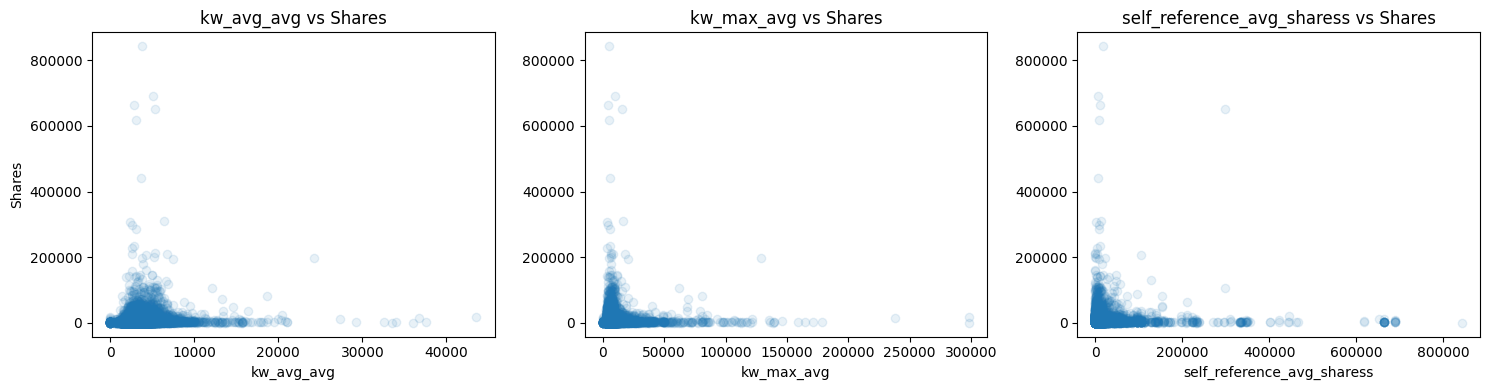

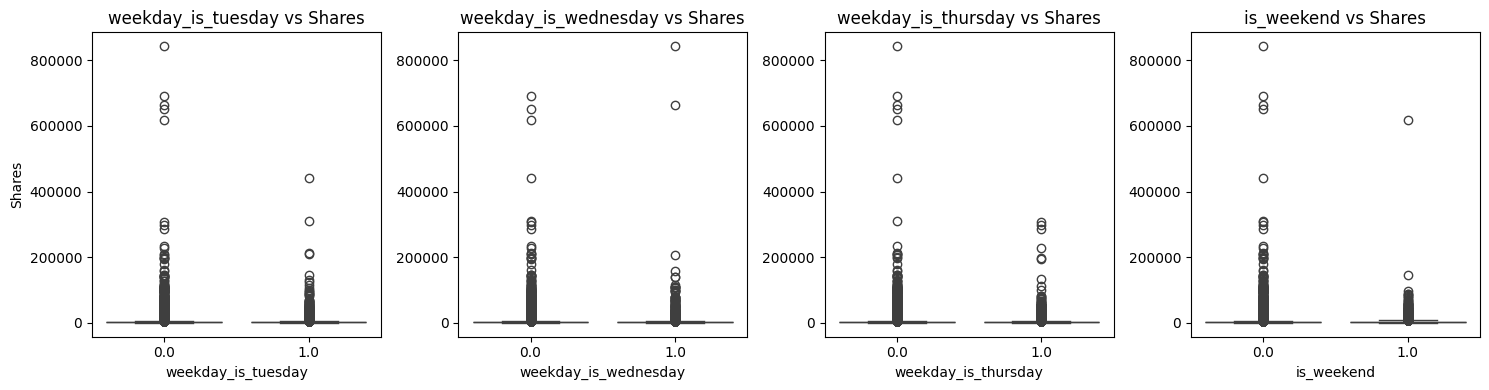

In [9]:
# 4. Select several significant features from steps 2 and 3. Create visualizations or
# tables to explore the relationships between these features and the target variable.
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_relationships(data, continuous_features, binary_features, target='shares'):
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(continuous_features, 1):
        plt.subplot(1, len(continuous_features), i)
        plt.scatter(data[feature], data[target], alpha=0.1)
        plt.xlabel(feature)
        plt.ylabel('Shares' if i == 1 else '')
        plt.title(f'{feature} vs Shares')
    plt.tight_layout()
    plt.show()
    
    # Plot binary features
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(binary_features, 1):
        plt.subplot(1, len(binary_features), i)
        sns.boxplot(x=feature, y=target, data=data)
        plt.ylabel('Shares' if i == 1 else '')
        plt.title(f'{feature} vs Shares')
    plt.tight_layout()
    plt.show()

continuous = ["kw_avg_avg", "kw_max_avg", "self_reference_avg_sharess", 
              "timedelta", "num_imgs"]
binary = ["weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday",
          "is_weekend", "data_channel_is_entertainment", "data_channel_is_tech"]

continuous = continuous[:-2]
binary = binary[:-2]

sig_features = continuous + binary

plot_feature_relationships(data, continuous, binary)

5. Write an EDA section in your technical report. Report the results of the initial models and include figures or tables that show the target variable and its
relationship with potentially significant predictors.

In [10]:
# 6. Use appropriate methods to remove insignificant variables from the model.
X = data.drop(["shares", "url"], axis=1).astype(float)
X = sm.add_constant(X)
y = np.log(data["shares"]).astype(float)

linear_model = sm.OLS(y, X).fit()

tuned_model, tuned_X = remove_insignificant_features(linear_model, X, y)
tuned_model.summary()

Removing self_reference_max_shares with p-value 0.9985226900284969
Removing avg_positive_polarity with p-value 0.9711122398764772
Removing weekday_is_saturday with p-value 0.9545461655077352
Removing is_weekend with p-value 0.954504779297568
Removing LDA_02 with p-value 0.9523481420501415
Removing min_negative_polarity with p-value 0.8893937148012816
Removing weekday_is_sunday with p-value 0.8860736278559992
Removing global_rate_negative_words with p-value 0.6270525305499173
Removing max_positive_polarity with p-value 0.3997371499615747
Removing n_non_stop_words with p-value 0.4461840216896025
Removing abs_title_sentiment_polarity with p-value 0.3781185119154119
Removing kw_max_max with p-value 0.25921229837016174
Removing data_channel_is_world with p-value 0.2210054254140665
Removing max_negative_polarity with p-value 0.21880833497861618
Removing num_videos with p-value 0.10673030213007241
Removing global_sentiment_polarity with p-value 0.07046144419701394
Removing self_reference_min_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     136.7
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:24:20   Log-Likelihood:                -50713.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39601   BIC:                         1.019e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.5863      0.054    122.400      0.000       6.481       6.692
timedelta                      5.821e-05   2.87e-05      2.031      0.042    2.04e-06       0.000
n_tokens_title                    0.0081      0.002      3.657      0.000       0.004       0.012
n_tokens_content               5.194e-05   1.26e-05      4.132      0.000    2.73e-05    7.66e-05
n_unique_tokens                   0.2624      0.109      2.399      0.016       0.048       0.477
n_non_stop_unique_tokens         -0.2799      0.118     -2.374      0.018      -0.511      -0.049
num_hrefs                         0.0042      0.001      8.441      0.000       0.003       0.005
num_self_hrefs                   -0.0080      0.001     -6.104      0.000      -0.011      -0.005
num_imgs                          0.0023      0.001      3.474      0.001       0.001       0.004
average_token_length             -0.0955      0.018     -5.341      0.000      -0.131      -0.060
num_keywords                      0.0124      0.003      4.458      0.000       0.007       0.018
data_channel_is_lifestyle        -0.0830      0.025     -3.270      0.001      -0.133      -0.033
data_channel_is_entertainment    -0.1647      0.017     -9.646      0.000      -0.198      -0.131
data_channel_is_bus              -0.1463      0.024     -6.080      0.000      -0.193      -0.099
data_channel_is_socmed            0.1828      0.023      7.887      0.000       0.137       0.228
data_channel_is_tech              0.1262      0.022      5.863      0.000       0.084       0.168
kw_min_min                        0.0008   8.64e-05      9.334      0.000       0.001       0.001
kw_max_min                     1.742e-05   3.81e-06      4.578      0.000    9.96e-06    2.49e-05
kw_avg_min                       -0.0001   2.34e-05     -5.498      0.000      -0.000   -8.28e-05
kw_min_max                    -3.716e-07   8.83e-08     -4.210      0.000   -5.45e-07   -1.99e-07
kw_avg_max                    -2.527e-07   6.05e-08     -4.177      0.000   -3.71e-07   -1.34e-07
kw_min_avg                    -5.138e-05    5.7e-06     -9.017      0.000   -6.25e-05   -4.02e-05
kw_max_avg                    -4.254e-05   1.89e-06    -22.512      0.000   -4.62e-05   -3.88e-05
kw_avg_avg                        0.0003   1.07e-05     31.601      0.000       0.000       0.000
self_reference_avg_sharess     1.946e-06   1.85e-07     10.525      0.000    1.58e-06    2.31e-06
weekday_is_monday                -0.2205      0.016    -13.573      0.000      -0.252      -0.189
weekday_is_tuesday               -0.2875      0.016    -18.108      0.000      -0.319      -0.256
weekday_is_wednesday             -0.2843      0.016    -17.902      0.000      -0.315      -0.253
weekday_is_thursday              -0.2789     

# Linear Regression Modeling 

In [47]:
# 1. Split the data into training and testing sets. Use the training set for model fitting
# and the testing set to check for overfitting and predictive performance.
X_train, X_test, y_train, y_test = train_test_split(X[sig_features], y, test_size=0.2, random_state=0)
X_train

,kw_avg_avg,kw_max_avg,self_reference_avg_sharess,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,is_weekend
8002,3387.545041,5255.942857,1300.0,0.0,0.0,1.0,0.0
3977,2412.119932,3933.904762,3700.0,0.0,0.0,0.0,0.0
32942,4697.088251,6010.020591,4300.0,0.0,1.0,0.0,0.0
33249,2740.541021,3781.925926,2060.0,1.0,0.0,0.0,0.0
29990,3093.589689,4972.250000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
20757,3130.463537,5397.650000,2050.0,0.0,0.0,1.0,0.0
32103,4881.433290,7581.226923,8300.0,0.0,0.0,1.0,0.0
30403,5638.004127,7191.255556,0.0,0.0,0.0,1.0,0.0
21243,2683.482028,3996.276753,7900.0,0.0,0.0,0.0,1.0


In [48]:
# 2. Explore transformations of the target and other variables.
print(X_train.columns)

X_train_cont = X_train.drop(binary, axis=1)
X_test_cont = X_test.drop(binary, axis=1)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), columns=X_train_cont.columns, index=X_train_cont.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_cont), columns=X_test_cont.columns, index=X_test_cont.index)

for feature in binary:
    print(f"Adding back {feature}")
    X_train_scaled[feature] = X_train[feature]
    X_test_scaled[feature] = X_test[feature]

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train_scaled), columns=poly.get_feature_names_out(X_train_scaled.columns), index=X_train_scaled.index)
X_test_poly = pd.DataFrame(poly.transform(X_test_scaled), columns=poly.get_feature_names_out(X_test_scaled.columns), index=X_test_scaled.index)

X_train_poly = X_train_poly.rename(columns={"1": "const"})
X_test_poly = X_test_poly.rename(columns={"1": "const"})

X_train_poly

Index(['kw_avg_avg', 'kw_max_avg', 'self_reference_avg_sharess',
       'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
       'is_weekend'],
      dtype='object')
Adding back weekday_is_tuesday
Adding back weekday_is_wednesday
Adding back weekday_is_thursday
Adding back is_weekend


,const,kw_avg_avg,kw_max_avg,self_reference_avg_sharess,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,is_weekend,kw_avg_avg kw_max_avg,kw_avg_avg self_reference_avg_sharess,...,self_reference_avg_sharess weekday_is_tuesday,self_reference_avg_sharess weekday_is_wednesday,self_reference_avg_sharess weekday_is_thursday,self_reference_avg_sharess is_weekend,weekday_is_tuesday weekday_is_wednesday,weekday_is_tuesday weekday_is_thursday,weekday_is_tuesday is_weekend,weekday_is_wednesday weekday_is_thursday,weekday_is_wednesday is_weekend,weekday_is_thursday is_weekend
8002,1.0,0.198829,-0.064191,-0.210893,0.0,0.0,1.0,0.0,-0.012763,-0.041932,...,-0.000000,-0.000000,-0.210893,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3977,1.0,-0.560396,-0.291273,-0.111802,0.0,0.0,0.0,0.0,0.163228,0.062653,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
32942,1.0,1.218116,0.065335,-0.087029,0.0,1.0,0.0,0.0,0.079585,-0.106011,...,-0.000000,-0.087029,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
33249,1.0,-0.304768,-0.317378,-0.179514,1.0,0.0,0.0,0.0,0.096727,0.054710,...,-0.179514,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29990,1.0,-0.029972,-0.112920,-0.264567,0.0,0.0,1.0,0.0,0.003384,0.007930,...,-0.000000,-0.000000,-0.264567,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,1.0,-0.001271,-0.039850,-0.179927,0.0,0.0,1.0,0.0,0.000051,0.000229,...,-0.000000,-0.000000,-0.179927,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
32103,1.0,1.361601,0.335216,0.078123,0.0,0.0,1.0,0.0,0.456431,0.106373,...,0.000000,0.000000,0.078123,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
30403,1.0,1.950480,0.268232,-0.264567,0.0,0.0,1.0,0.0,0.523181,-0.516033,...,-0.000000,-0.000000,-0.264567,-0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21243,1.0,-0.349181,-0.280560,0.061608,0.0,0.0,0.0,1.0,0.097966,-0.021512,...,0.000000,0.000000,0.000000,0.061608,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
poly_model = sm.OLS(y_train, X_train_poly).fit()
mse = mean_squared_error(y_test, poly_model.predict(X_test_poly))
print(f"Mean Squared Error (initial): {mse}")
r2 = r2_score(y_test, poly_model.predict(X_test_poly))
print(f"R^2 (initial): {r2}")

tuned_poly_model, tuned_X_poly_train = remove_insignificant_features(poly_model, X_train_poly, y_train, p=0.000000000001)
tuned_X_poly_test = X_test_poly[tuned_X_poly_train.columns]
print(f"Mean Squared Error (tuned): {mean_squared_error(y_test, tuned_poly_model.predict(tuned_X_poly_test))}")
print(f"R^2 (tuned): {r2_score(y_test, tuned_poly_model.predict(tuned_X_poly_test))}")

Mean Squared Error (initial): 0.7968469927674533
R^2 (initial): 0.07402754873725403
Removing self_reference_avg_sharess weekday_is_wednesday with p-value 0.9545105095411652
Removing self_reference_avg_sharess weekday_is_tuesday with p-value 0.890669026535077
Removing kw_avg_avg weekday_is_wednesday with p-value 0.5769936727987652
Removing kw_avg_avg weekday_is_tuesday with p-value 0.4262994776650181
Removing kw_max_avg self_reference_avg_sharess with p-value 0.3459006507309884
Removing kw_max_avg weekday_is_thursday with p-value 0.168545662242319
Removing kw_avg_avg weekday_is_thursday with p-value 0.3313852791944033
Removing kw_max_avg weekday_is_tuesday with p-value 0.1495258813025144
Removing kw_max_avg weekday_is_wednesday with p-value 0.058473102675089574
Removing self_reference_avg_sharess weekday_is_thursday with p-value 0.016451792735539494
Removing self_reference_avg_sharess is_weekend with p-value 0.04751201196408713
Removing kw_avg_avg self_reference_avg_sharess with p-value

In [14]:
# 3. Explore higher-order terms.
X_train_higher = X_train.copy()
X_test_higher = X_test.copy()

higher_order = PolynomialFeatures(degree=2, include_bias=False)

X_train_higher[higher_order.get_feature_names_out(X_train_cont.columns)] = pd.DataFrame(higher_order.fit_transform(X_train_higher[X_train_cont.columns]), columns=higher_order.get_feature_names_out(X_train_cont.columns), index=X_train_higher.index)

X_test_higher[higher_order.get_feature_names_out(X_train_cont.columns)] = pd.DataFrame(higher_order.transform(X_test_higher[X_train_cont.columns]), columns=higher_order.get_feature_names_out(X_train_cont.columns), index=X_test_higher.index)

# X_train_higher = X_train_higher.rename(columns={"1": "const"})
# X_test_higher = X_test_higher.rename(columns={"1": "const"})
X_train_higher = sm.add_constant(X_train_higher, has_constant='add')
X_test_higher = sm.add_constant(X_test_higher, has_constant='add')

X_train_higher.head()


,const,kw_avg_avg,kw_max_avg,self_reference_avg_sharess,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,is_weekend,kw_avg_avg^2,kw_avg_avg kw_max_avg,kw_avg_avg self_reference_avg_sharess,kw_max_avg^2,kw_max_avg self_reference_avg_sharess,self_reference_avg_sharess^2
8002,1.0,3387.545041,5255.942857,1300.0,0.0,0.0,1.0,0.0,1.147546e+07,1.780474e+07,4.403809e+06,2.762494e+07,6.832726e+06,1690000.0
3977,1.0,2412.119932,3933.904762,3700.0,0.0,0.0,0.0,0.0,5.818323e+06,9.489050e+06,8.924844e+06,1.547561e+07,1.455545e+07,13690000.0
32942,1.0,4697.088251,6010.020591,4300.0,0.0,1.0,0.0,0.0,2.206264e+07,2.822960e+07,2.019748e+07,3.612035e+07,2.584309e+07,18490000.0
33249,1.0,2740.541021,3781.925926,2060.0,1.0,0.0,0.0,0.0,7.510565e+06,1.036452e+07,5.645515e+06,1.430296e+07,7.790767e+06,4243600.0
29990,1.0,3093.589689,4972.250000,0.0,0.0,0.0,1.0,0.0,9.570297e+06,1.538210e+07,0.000000e+00,2.472327e+07,0.000000e+00,0.0


In [15]:

higher_model = sm.OLS(y_train, X_train_higher).fit()
higher_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     234.1
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:24:21   Log-Likelihood:                -41287.
No. Observations:               31715   AIC:                         8.260e+04
Df Residuals:                   31701   BIC:                         8.272e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     6.7352      0.028    239.778      0.000       6.680       6.790
kw_avg_avg                                0.0003   2.03e-05     13.471      0.000       0.000       0.000
kw_max_avg                            -2.083e-05   3.85e-06     -5.412      0.000   -2.84e-05   -1.33e-05
self_reference_avg_sharess             8.615e-06    7.3e-07     11.799      0.000    7.18e-06       1e-05
weekday_is_tuesday                       -0.0660      0.015     -4.504      0.000      -0.095      -0.037
weekday_is_wednesday                     -0.0676      0.015     -4.632      0.000      -0.096      -0.039
weekday_is_thursday                      -0.0558      0.015     -3.793      0.000      -0.085      -0.027
is_weekend                                0.2409      0.016     14.671      0.000       0.209       0.273
kw_avg_avg^2                          -1.772e-09   3.68e-09     -0.481      0.630   -8.98e-09    5.44e-09
kw_avg_avg kw_max_avg                  -9.77e-10   1.18e-09     -0.827      0.408   -3.29e-09    1.34e-09
kw_avg_avg self_reference_avg_sharess -3.418e-10   2.01e-10     -1.701      0.089   -7.36e-10    5.21e-11
kw_max_avg^2                           8.451e-11   8.77e-11      0.963      0.335   -8.75e-11    2.56e-10
kw_max_avg self_reference_avg_sharess  4.443e-11   2.92e-11      1.524      0.128   -1.27e-11    1.02e-10
self_reference_avg_sharess^2          -1.201e-11   8.64e-13    -13.902      0.000   -1.37e-11   -1.03e-11
==============================================================================
Omnibus:                     5221.171   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12673.075
Skew:                           0.933   Prob(JB):                         0.00
Kurtosis:                       5.472   Cond. No.                     7.10e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.1e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# out of sample performance
print(f"Mean Squared Error (initial): {mean_squared_error(y_test, higher_model.predict(X_test_higher))}")
print(f"R^2 (initial): {r2_score(y_test, higher_model.predict(X_test_higher))}")

tuned_higher_model, tuned_X_higher_train = remove_insignificant_features(higher_model, X_train_higher, y_train, p=0.000000000001)

tuned_X_higher_test = X_test_higher[tuned_X_higher_train.columns]

print(f"Mean Squared Error (tuned): {mean_squared_error(y_test, tuned_higher_model.predict(tuned_X_higher_test))}")
print(f"R^2 (tuned): {r2_score(y_test, tuned_higher_model.predict(tuned_X_higher_test))}")

tuned_higher_model.summary()

Mean Squared Error (initial): 0.786928262858291
R^2 (initial): 0.08555356405859249
Removing kw_avg_avg^2 with p-value 0.6301787999121551
Removing kw_max_avg self_reference_avg_sharess with p-value 0.11850126032093904
Removing kw_avg_avg self_reference_avg_sharess with p-value 0.43182028049987264
Removing weekday_is_thursday with p-value 0.00015431036804883902
Removing weekday_is_tuesday with p-value 0.000787150170021318
Removing weekday_is_wednesday with p-value 0.007808248951408501
Removing kw_max_avg^2 with p-value 1.9740292401717206e-07
Mean Squared Error (tuned): 0.79036052116747
R^2 (tuned): 0.081565123782399


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 shares   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     495.8
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:24:21   Log-Likelihood:                -41318.
No. Observations:               31715   AIC:                         8.265e+04
Df Residuals:                   31708   BIC:                         8.271e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            6.7389      0.016    421.906      0.000       6.708       6.770
kw_avg_avg                       0.0002   6.75e-06     36.794      0.000       0.000       0.000
kw_max_avg                   -1.842e-05   2.18e-06     -8.432      0.000   -2.27e-05   -1.41e-05
self_reference_avg_sharess    7.569e-06   4.34e-07     17.458      0.000    6.72e-06    8.42e-06
is_weekend                       0.2825      0.015     19.103      0.000       0.254       0.311
kw_avg_avg kw_max_avg        -6.758e-10   8.45e-11     -7.996      0.000   -8.41e-10    -5.1e-10
self_reference_avg_sharess^2 -1.185e-11   8.51e-13    -13.934      0.000   -1.35e-11   -1.02e-11
==============================================================================
Omnibus:                     5218.090   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12678.561
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       5.474   Cond. No.                     3.95e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
"""4. Reduce the model using the following methods:
• Stepwise model evaluation methods to remove insignificant variables.
• LASSO regression to fit the full model and remove insignificant variables.
Tune the model to find the best a."""

print("We've used stepwise model evaluation methods to remove insignificant variables for the previous models, see above.")


We've used stepwise model evaluation methods to remove insignificant variables for the previous models, see above.


In [18]:

from sklearn.linear_model import Lasso


X_train_ultra = X_train.copy()
X_test_ultra = X_test.copy()

ultra_poly = PolynomialFeatures(degree=3, include_bias=False)

X_train_ultra = pd.DataFrame(ultra_poly.fit_transform(X_train_ultra), columns=ultra_poly.get_feature_names_out(X_train_ultra.columns), index=X_train_ultra.index)
X_test_ultra = pd.DataFrame(ultra_poly.transform(X_test_ultra), columns=ultra_poly.get_feature_names_out(X_test_ultra.columns), index=X_test_ultra.index)

scaler = StandardScaler()

X_train_ultra = pd.DataFrame(scaler.fit_transform(X_train_ultra), columns=X_train_ultra.columns, index=X_train_ultra.index)
X_test_ultra = pd.DataFrame(scaler.transform(X_test_ultra), columns=X_test_ultra.columns, index=X_test_ultra.index)

X_train_ultra = sm.add_constant(X_train_ultra, has_constant='add')
X_test_ultra = sm.add_constant(X_test_ultra, has_constant='add')

X_train_ultra.head()

,const,kw_avg_avg,kw_max_avg,self_reference_avg_sharess,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,is_weekend,kw_avg_avg^2,kw_avg_avg kw_max_avg,...,weekday_is_wednesday^3,weekday_is_wednesday^2 weekday_is_thursday,weekday_is_wednesday^2 is_weekend,weekday_is_wednesday weekday_is_thursday^2,weekday_is_wednesday weekday_is_thursday is_weekend,weekday_is_wednesday is_weekend^2,weekday_is_thursday^3,weekday_is_thursday^2 is_weekend,weekday_is_thursday is_weekend^2,is_weekend^3
8002,1.0,0.198829,-0.064191,-0.210893,-0.476624,-0.480158,2.118260,-0.390321,0.000729,-0.051145,...,-0.480158,0.0,0.0,0.0,0.0,0.0,2.118260,0.0,0.0,-0.390321
3977,1.0,-0.560396,-0.291273,-0.111802,-0.476624,-0.480158,-0.472086,-0.390321,-0.277544,-0.123919,...,-0.480158,0.0,0.0,0.0,0.0,0.0,-0.472086,0.0,0.0,-0.390321
32942,1.0,1.218116,0.065335,-0.087029,-0.476624,2.082649,-0.472086,-0.390321,0.521509,0.040086,...,2.082649,0.0,0.0,0.0,0.0,0.0,-0.472086,0.0,0.0,-0.390321
33249,1.0,-0.304768,-0.317378,-0.179514,2.098089,-0.480158,-0.472086,-0.390321,-0.194303,-0.116257,...,-0.480158,0.0,0.0,0.0,0.0,0.0,-0.472086,0.0,0.0,-0.390321
29990,1.0,-0.029972,-0.112920,-0.264567,-0.476624,-0.480158,2.118260,-0.390321,-0.092986,-0.072347,...,-0.480158,0.0,0.0,0.0,0.0,0.0,2.118260,0.0,0.0,-0.390321


In [19]:
lasso = Lasso(alpha=0.01)

no_reg = sm.OLS(y_train, X_train_ultra).fit()

print(f"Mean Squared Error (initial): {mean_squared_error(y_test, no_reg.predict(X_test_ultra))}")
print(f"R^2 (initial): {r2_score(y_test, no_reg.predict(X_test_ultra))}")

lasso.fit(X_train_ultra, y_train)

print(f"Mean Squared Error (Lasso): {mean_squared_error(y_test, lasso.predict(X_test_ultra))}")
print(f"R^2 (Lasso): {r2_score(y_test, lasso.predict(X_test_ultra))}")

lasso_summary = pd.DataFrame({'Feature': X_train_ultra.columns, 'Coefficient': lasso.coef_}).sort_values('Coefficient', key=lambda x: abs(x), ascending=False)

print("The non-zero coefficients are:")
for i, row in lasso_summary.iterrows():
    if row['Coefficient'] != 0:
        print(f"{row['Feature']:50}: {row['Coefficient']}")

Mean Squared Error (initial): 0.8197072127709436
R^2 (initial): 0.04746293326506512
Mean Squared Error (Lasso): 0.7940622024095766
R^2 (Lasso): 0.0772636018030759
The non-zero coefficients are:
kw_avg_avg                                        : 0.27451087887895553
self_reference_avg_sharess                        : 0.10584308639827258
kw_avg_avg kw_max_avg                             : -0.08654886655453249
is_weekend                                        : 0.08205057687281696
self_reference_avg_sharess^2                      : -0.06833830848546153
kw_max_avg                                        : -0.03779546168711138
kw_avg_avg kw_max_avg weekday_is_wednesday        : -0.010293663106059702
kw_max_avg weekday_is_tuesday                     : -0.00978045606559039
kw_max_avg^2 weekday_is_wednesday                 : -0.005948111988488734
weekday_is_wednesday                              : -0.004270547432391294
weekday_is_thursday                               : -0.002556527418051246
kw

5. Write a section in your technical report that reports the out-of-sample performance of the models. Discuss the most significant predictors and evaluate the model's usefulness for predicting future shares.

In [50]:
# Linear Regression
linear_model = sm.OLS(y_train, X_train_scaled).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 shares   R-squared (uncentered):                   0.677
Model:                            OLS   Adj. R-squared (uncentered):              0.677
Method:                 Least Squares   F-statistic:                              9512.
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                        0.00
Time:                        17:12:39   Log-Likelihood:                         -91102.
No. Observations:               31715   AIC:                                  1.822e+05
Df Residuals:                   31708   BIC:                                  1.823e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
kw_avg_avg                     0.2484      0.041      6.126      0.000       0.169       0.328
kw_max_avg                    -0.1493      0.041     -3.683      0.000      -0.229      -0.070
self_reference_avg_sharess     0.0699      0.024      2.856      0.004       0.022       0.118
weekday_is_tuesday             7.4121      0.056    132.727      0.000       7.303       7.522
weekday_is_wednesday           7.4093      0.056    133.460      0.000       7.301       7.518
weekday_is_thursday            7.4209      0.056    131.850      0.000       7.311       7.531
is_weekend                     7.7269      0.066    116.774      0.000       7.597       7.857
==============================================================================
Omnibus:                    23156.096   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4776.885
Skew:                           0.751   Prob(JB):                         0.00
Kurtosis:                       1.835   Cond. No.                         3.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Linear Regression
linear_mse = mean_squared_error(y_test, linear_model.predict(X_test_scaled))
linear_r2 = r2_score(y_test, linear_model.predict(X_test_scaled))

# Interactions Regression
poly_mse = mean_squared_error(y_test, tuned_poly_model.predict(tuned_X_poly_test))
poly_r2 = r2_score(y_test, tuned_poly_model.predict(tuned_X_poly_test))

# Higher-order Regression
higher_mse = mean_squared_error(y_test, tuned_higher_model.predict(tuned_X_higher_test))
higher_r2 = r2_score(y_test, tuned_higher_model.predict(tuned_X_higher_test))

# Lasso Regression
lasso_mse = mean_squared_error(y_test, lasso.predict(X_test_ultra))
lasso_r2 = r2_score(y_test, lasso.predict(X_test_ultra))

# Print the results
print("Out-of-Sample Performance Comparison:")
print(f"{'Linear Regression - MSE:':30} {linear_mse:.4f}, R2: {linear_r2:.4f}")
print(f"{'Polynomial Regression - MSE:':30} {poly_mse:.4f}, R2: {poly_r2:.4f}")
print(f"{'Higher-order Regression - MSE:':30} {higher_mse:.4f}, R2: {higher_r2:.4f}")
print(f"{'Lasso Regression - MSE:':30} {lasso_mse:.4f}, R2: {lasso_r2:.4f}")

Out-of-Sample Performance Comparison:
Linear Regression - MSE:       17.9056, R2: -19.8071
Polynomial Regression - MSE:   0.7985, R2: 0.0721
Higher-order Regression - MSE: 0.7904, R2: 0.0816
Lasso Regression - MSE:        0.7941, R2: 0.0773


It appears that the tuned Higher-order Regression model preformed the best with the lowest MSE and highest R^2 values. This is because we did recursive feature elimination to select the most statistically significant features. This indicates that this model will likely perform well on future data, if it is within our training data's distribution (ie. not extrapolating). Since we have polynomial features, overfitting and extrapolation would pose a significant risk.

# Regression Tree Modeling

[Text(0.5, 0.875, 'const <= 3085.199\nsquared_error = 0.867\nsamples = 31715\nvalue = 7.475'),
 Text(0.25, 0.625, 'n_tokens_title <= 1915.333\nsquared_error = 0.675\nsamples = 18820\nvalue = 7.298'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'n_non_stop_unique_tokens <= 0.5\nsquared_error = 0.64\nsamples = 9771\nvalue = 7.177'),
 Text(0.0625, 0.125, 'squared_error = 0.624\nsamples = 8609\nvalue = 7.137'),
 Text(0.1875, 0.125, 'squared_error = 0.66\nsamples = 1162\nvalue = 7.476'),
 Text(0.375, 0.375, 'timedelta <= 3645.459\nsquared_error = 0.68\nsamples = 9049\nvalue = 7.428'),
 Text(0.3125, 0.125, 'squared_error = 0.562\nsamples = 4521\nvalue = 7.318'),
 Text(0.4375, 0.125, 'squared_error = 0.774\nsamples = 4528\nvalue = 7.539'),
 Text(0.75, 0.625, 'n_tokens_title <= 2958.94\nsquared_error = 1.035\nsamples = 12895\nvalue = 7.734'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'const <= 4241.163\nsquared_error = 0.914\nsamples = 6222\nvalue = 7.571'),
 Text(0.5625, 0.125,

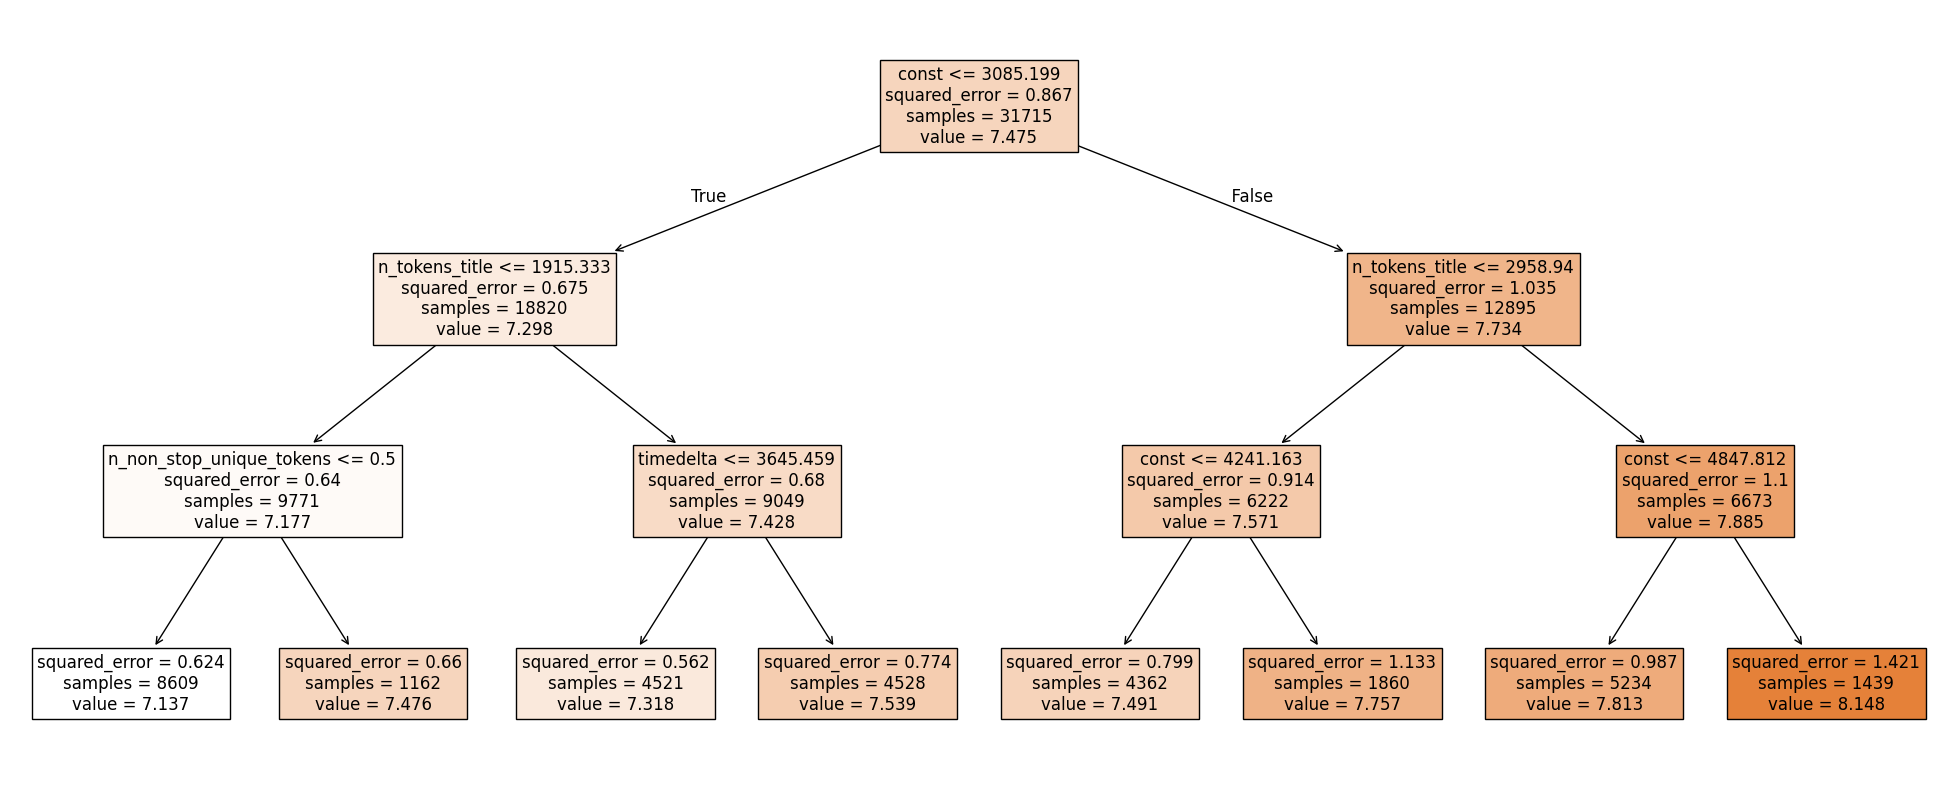

In [53]:
# 2. Use cost-complexity pruning and cross-validation to find a model that fits well
# on out-of-sample data.
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
tree_prep = DecisionTreeRegressor(max_depth = 3)
mod_tree = tree_prep.fit(X_train,y_train)
plt.figure(figsize = (25,10))
tree.plot_tree(mod_tree, feature_names=X.columns, filled = True,fontsize = 12)

In [54]:
preds = mod_tree.predict(X_test)
r2_score(y_test,preds)

0.08237479523048763

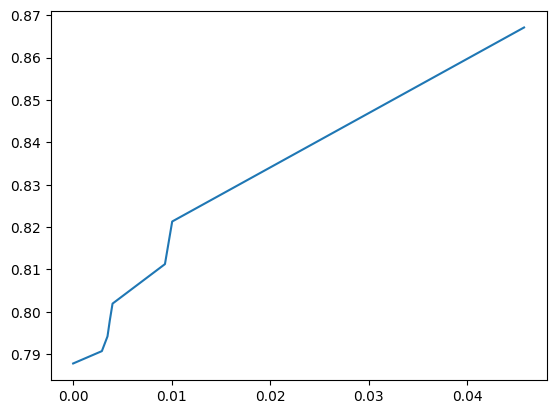

In [55]:
tree_prep = DecisionTreeRegressor()
path = mod_tree.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, MSEs = path.ccp_alphas, path.impurities
plt.plot(ccp_alphas,MSEs)

In [56]:
import numpy as np
from sklearn.metrics import r2_score

alphas = np.linspace(0, 0.01, 15)
best_alpha = 0
best_r2 = -1

for alpha in alphas:
    tree_prep = DecisionTreeRegressor(ccp_alpha=alpha)
    tree_prep.fit(X_train, y_train)
    preds = tree_prep.predict(X_test)
    current_r2 = r2_score(y_test, preds)

    if current_r2 > best_r2:
      best_r2 = current_r2
      best_alpha = alpha
      best_mse = mean_squared_error(y_test, preds)
      print("New best alpha found:", best_alpha, "with R^2:", best_r2)

print(f"The best alpha found is: {best_alpha}")
print(f"The corresponding R^2 is: {best_r2}")
print(f"The best MSE found:{best_mse}")

New best alpha found: 0.0 with R^2: -0.8562380156901119
New best alpha found: 0.0007142857142857143 with R^2: 0.09312616962971854
The best alpha found is: 0.0007142857142857143
The corresponding R^2 is: 0.09312616962971854
The best MSE found:0.7804116456862175


In [57]:
# 3. Fit a random forest regression model, using cost-complexity pruning for the individual trees.
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42, ccp_alpha=0.01)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

In Sample R^2:  0.07043643659171228
Out Of Sample R^2:  0.06855623248052256
MSE: 0.8015553422434132


In [58]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42, ccp_alpha=0.0007)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

In Sample R^2:  0.12437178670680837
Out Of Sample R^2:  0.10226447014898454
MSE: 0.7725476673595922


In [59]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("In Sample R^2: ",r2_score(y_train,regressor.predict(X_train)))
print("Out Of Sample R^2: ",r2_score(y_test,y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

In Sample R^2:  0.8636233454373461
Out Of Sample R^2:  0.03157078462882257
MSE: 0.8333832253047224


4. Write a section in your technical report that reports the out-of-sample performance of the models. Discuss the model's usefulness for predicting future shares.

For our regular regression tree, the best out of sample performance we got was a 0.093 R^2 value when using an alpha value of ~0.0007 and an MSE of 0.780.

After testing a few different value random forest models with different alpha values, the best one we found was to have an out of sample R^2 of 0.10 using a alpha value of 0.0007 and an MSE of 0.772.

Because the R^2 is so low for all of these models, that would not be very useful for predicting future shares. If one of the tree models was chosen, the regular regression tree model was chosen because it has the hightest R^2 value.

# Conclusion

Compare each model’s predictive accuracy on the test set. Choose the
best-performing model as the final predictive model. Write a concluding section in
your technical report that addresses Mashable?s business concerns and presents your
final model along with your confidence in its predictions.

In [61]:
# Convert MSE back to log scale
print(f"Lin Reg Original:{np.exp(17.9)}")
print(f"Lin Reg Poly Original:{np.exp(0.7985)}")
print(f"Lin Reg Higher Original:{np.exp(0.7904)}")
print(f"Lasso Original:{np.exp(0.7941)}")
print(f"Tree Original:{np.exp(0.780)}")
print(f"Random Forest Original:{np.exp(0.772)}")

Lin Reg Original:59411596.94254284
Lin Reg Poly Original:2.222205119581876
Lin Reg Higher Original:2.2042779611216585
Lasso Original:2.2124488964865603
Tree Original:2.181472265498201
Random Forest Original:2.1640901087061213


Comparison of model accuracies on the test set

Linear Regression 
- MSE: 59411596.94254284
- R^2: -19.8071
Linear Regression (Polynomial Terms)
- MSE: 2.2222
- R^2: 0.0721
Linear Regression (Higher Order Features)
- MSE: 2.2042
- R^2: 0.0816
Lasso Regression:
- MSE: 2.2124
- R^2: 0.0773
Regression Tree:
- MSE: 2.1814
- R^2: 0.093
Random Forest:
- MSE: 2.164
- R^2: 0.10



AFter evaluating a variety of different models, we have found the best model for predicting how many shares an article will get is a random forest model.